# SubBeamNod Data Reduction

This notebook shows how to use `dysh` to calibrate an SubBeamNod observation via two different methods. It retrieves and calibrates SubBeamNod scans using `GBTFITSLoad.subbeamnod()` which returns a `ScanBlock` object. 

## Dysh commands

The following dysh commands are introduced (leaving out all the function arguments):

    filename = dysh_data()
    sdf = GBTFITSLoad()
    sdf.select()
    sb = sdf.subbeamnod()
    ta = sb.timeaverage()
    ta.baseline()
    ta.average()
    ta.plot()

## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) `matplotlib` backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on `jupyter` lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for working with the data.
from dysh.log import init_logging
from dysh.fits.gbtfitsload import GBTFITSLoad

# These modules are used for file I/O
from dysh.util.files import dysh_data
from pathlib import Path

In [2]:
init_logging(2)

# also create a local "output" directory where temporary notebook files can be stored.
output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

## Data Retrieval

Download the example SDFITS data, if necessary.

In [3]:
filename = dysh_data(example="subbeamnod")

13:03:59.767 I Resolving example=subbeamnod -> subbeamnod/data/AGBT13A_124_06/AGBT13A_124_06.raw.acs/AGBT13A_124_06.raw.acs.fits


## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [4]:
sdfits = GBTFITSLoad(filename)

The returned `sdfits` can be probed for information.
You can also print a concise (or verbose if you choose verbose=True) summary of the data.

In [5]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
44,vIIzw31,16090.0,SubBeamNod,1,48.940955,48.990955,2,2,100,2,353.8967,47.7582


There is only one scan, using SubBeamNod. The scan is 44.


## Data Reduction

### Single Scan

To retrieve and calibrate a SubBeamNod scan we use `sdfits.subbeamnod()`. This method returns a `ScanBlock`, with one element per scan and per intermediate frequency. 

#### Calibration per Cycle

There are two different methods for calibrating a SubBeamNod scan. The first, with `method="cycle"` (the default) averages the data in each subreflector state for each cycle of integrations. That is, it separates the data into one signal/reference pair for each pair of subreflector states (on source and off source). Then calibrates each signal/reference pair independently and finally time averages the calibrated spectra.

In [6]:
sbn_scan_block = sdfits.subbeamnod(scan=44, fdnum=1, ifnum=0, plnum=0, method='cycle')

#### Time Averaging

To time average the contents of a `ScanBlock` use its `timeaverage` method. Be aware that time averging will not check if the source is the same. 

By default time averaging uses the following weights: 
$$
\frac{T^{2}_{sys}}{\Delta\nu\Delta t}
$$
with $T_{sys}$ the system temperature, $\Delta\nu$ the channel width and $\Delta t$ the integration time. In `dysh` these are set using `weights='tsys'` (the default).

In [7]:
ta = sbn_scan_block.timeaverage()

#### Plotting

Plot the data and use different units for the spectral axis.

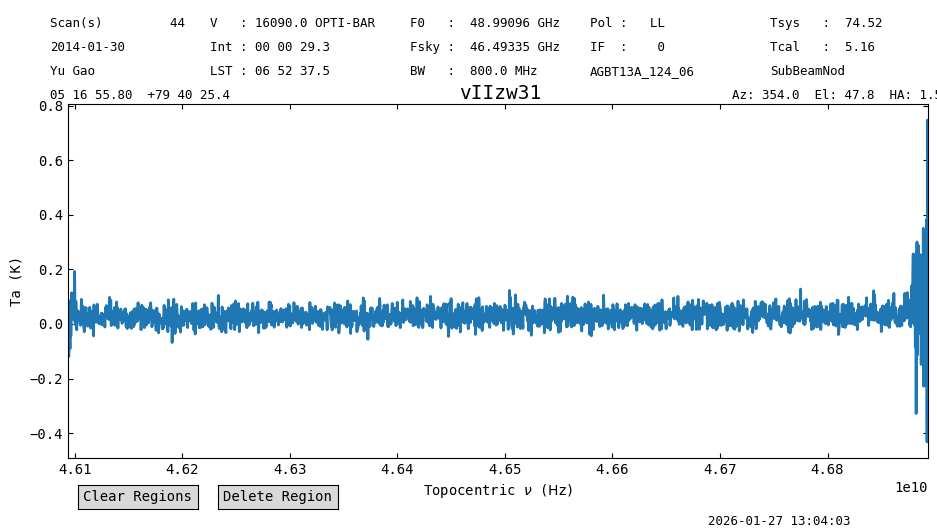

In [8]:
ta.plot()

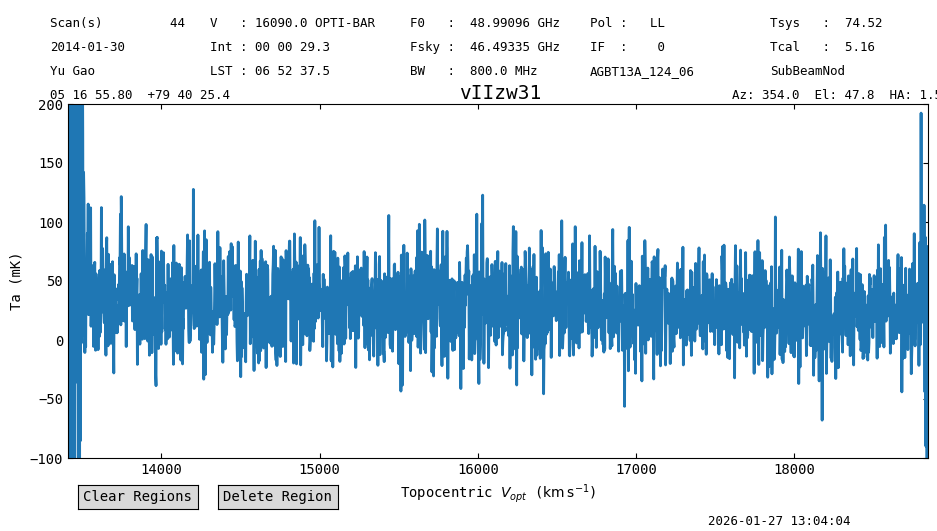

In [9]:
ta.plot(xaxis_unit="km/s", yaxis_unit="mK", ymin=-100, ymax=200)

#### Calibration per Scan
The second method (`method="scan"`) of calibrating SubBeamNod scans reproduces the method of GBTIDL's `snodka.pro`. This method treats the entire group of integrations as one cycle. It first time averages all of the integrations on source and off source, and then calibrates using the time averages.

In [10]:
sbn_scan_block2 = sdfits.subbeamnod(scan=44, fdnum=1, ifnum=0, plnum=0, method='scan')

In [11]:
ta2 = sbn_scan_block2.timeaverage()

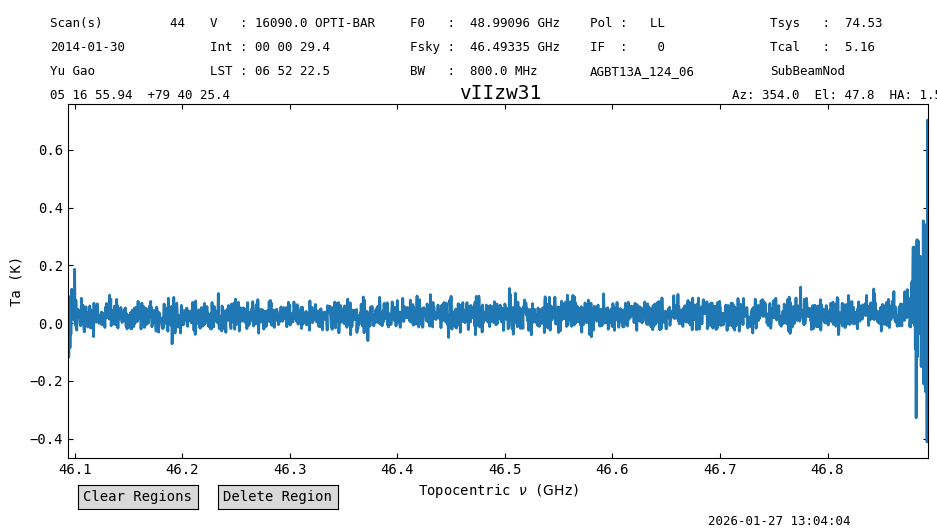

In [12]:
ta2.plot(xaxis_unit="GHz")

1.2630467493960695

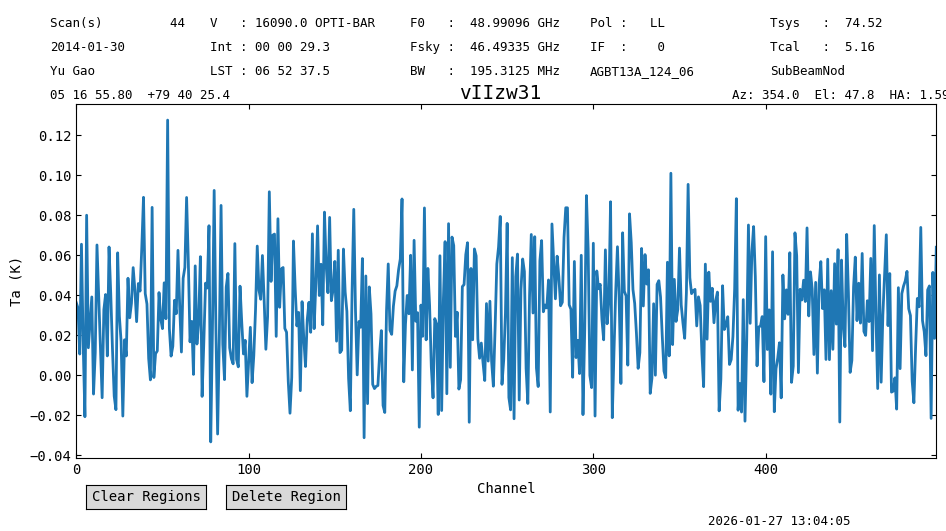

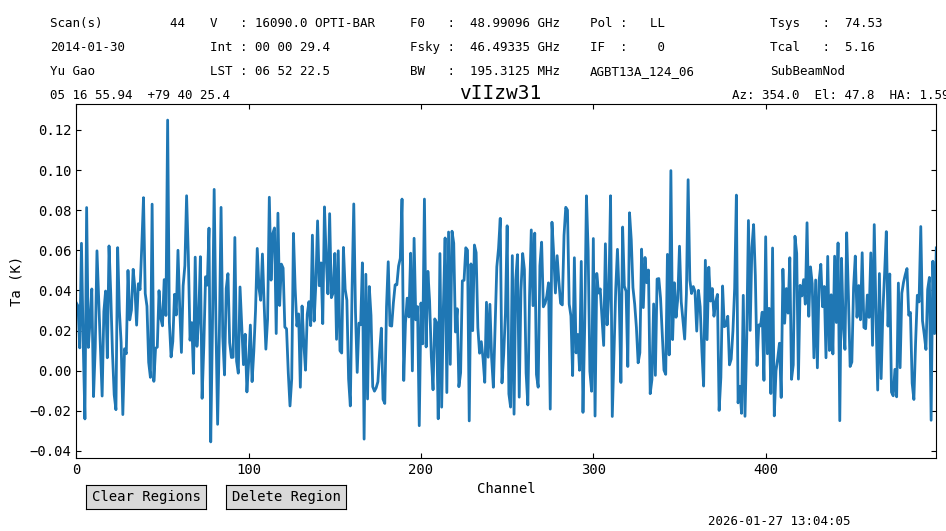

In [13]:
ta[250:750].plot(xaxis_unit="chan").spectrum.radiometer() # 1.2611058840974072
ta2[250:750].plot(xaxis_unit="chan").spectrum.radiometer() # 1.2630467493960695

#### Compare the Two Methods


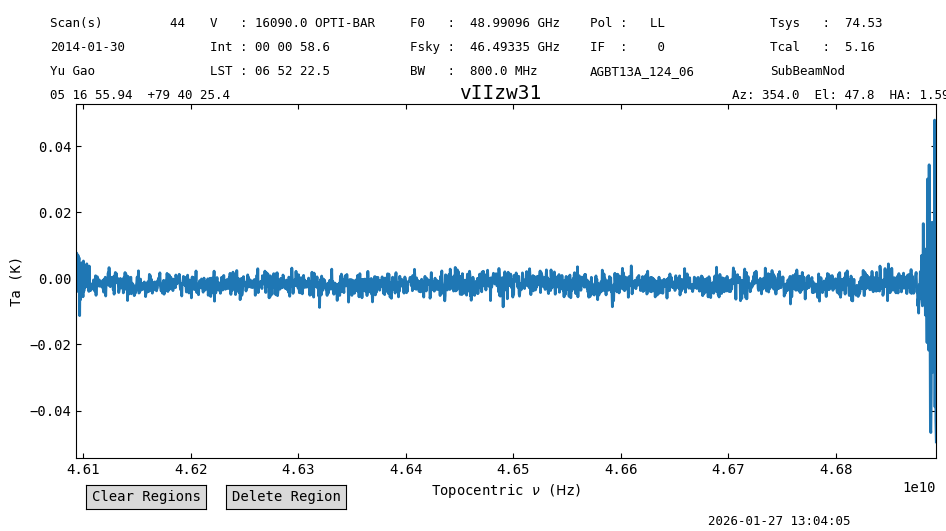

In [14]:
(ta2 - ta).plot()

---------------

#### Using Selection

We will repeat the calibration but using selection. First we pre-select the data to be calibrated using the `sdfits.select()` method.

In [15]:
sdfits.select(scan=44)
sdfits.selection.show()

 ID    TAG    SCAN # SELECTED
--- --------- ---- ----------
  0 85584afb9   44       1600


After using selection, the calibration routines will only look for data matching the selection rules. It is also possible to add additional rules for a specific calibration, like the polarization number.

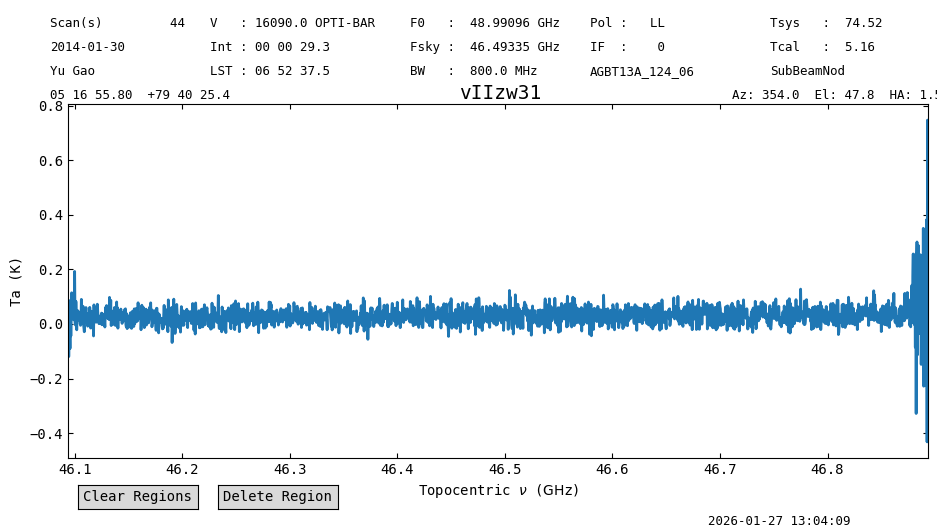

In [16]:
sbn_scan_block3 = sdfits.subbeamnod(plnum=0, fdnum=1, ifnum=0)
ta3 = sbn_scan_block3.timeaverage()
ta3.plot(xaxis_unit="GHz")

#### Polarization Average

Now we will calibrate the other polarization and average the two polarizations together.

First we calibrate the second polarization, then time average it and finally we average them together.

In [17]:
sbn_scan_block4 = sdfits.subbeamnod(plnum=1, fdnum=0, ifnum=0)
ta4 = sbn_scan_block4.timeaverage()
pol_avg = ta3.average(ta4)

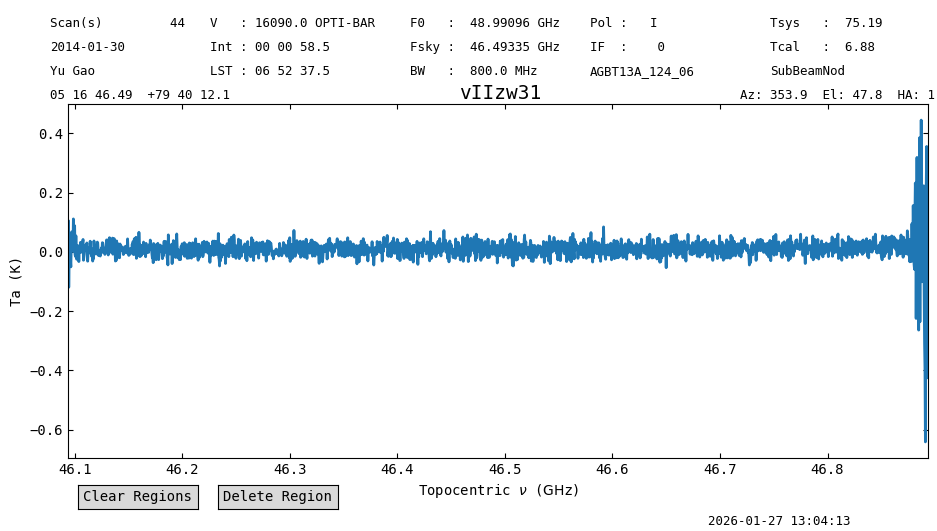

In [18]:
pol_avg.plot(xaxis_unit="GHz")

## Final Stats

In [19]:
pol_avg.stats()  # rms 0.03836776 K

{'mean': <Quantity 0.00987483 K>,
 'median': <Quantity 0.00985914 K>,
 'rms': <Quantity 0.03836776 K>,
 'min': <Quantity -0.64145578 K>,
 'max': <Quantity 0.44475291 K>,
 'npt': 2048,
 'nan': 0}

1.2538633771107366

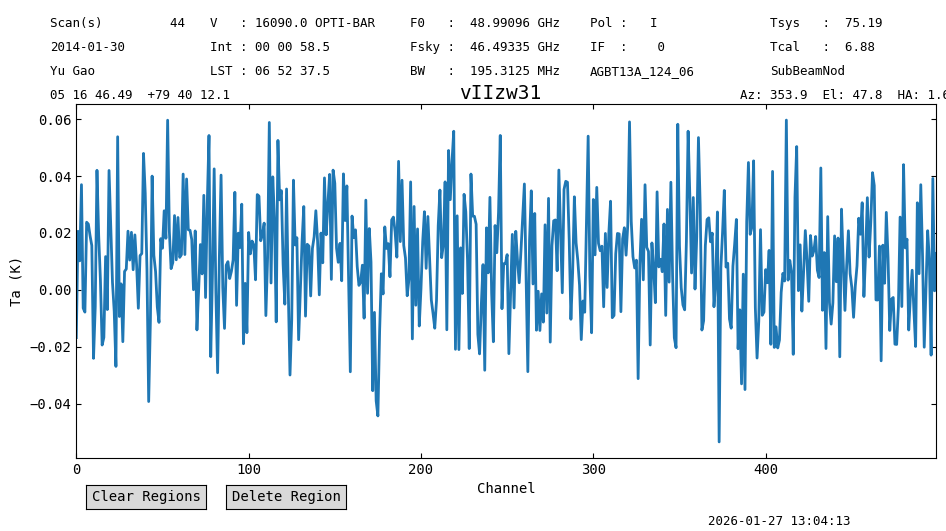

In [20]:
pol_avg[250:750].plot(xaxis_unit="chan").spectrum.radiometer()  # 1.2538633771107366